In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup, Comment
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
import warnings
from tqdm.autonotebook import tqdm, trange

C:\Users\Мария\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [6]:
#warnings.filterwarnings("ignore", category=FutureWarning, message="`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.")

In [11]:
def extract_joke_from_html(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'lxml')
        start_comment = soup.find(string=lambda text: isinstance(text, Comment) and 'begin of joke' in text)
        end_comment = soup.find(string=lambda text: isinstance(text, Comment) and 'end of joke' in text)

        if start_comment and end_comment:
            joke = ''
            for element in start_comment.next_elements:
                if element == end_comment:
                    break
                if isinstance(element, str):
                    joke += element.strip() + ' '
                elif hasattr(element, 'get_text') and element.name != 'p':
                    joke += element.get_text(separator=" ").strip() + ' '

            joke = joke.strip()
        else:
            joke = None
    return joke

html_dir = './jokes'

jokes = []
for i in range(1, 101):
    file_path = os.path.join(html_dir, f'init{i}.html')
    joke = extract_joke_from_html(file_path)
    jokes.append(joke)

excel_file = './jester-data-1.xls'
df = pd.read_excel(excel_file, header=None, names=[chr(ord('A') + i) for i in range(101)])
df.replace(99, np.nan, inplace=True)

ratings = df.iloc[:, 1:].values.flatten()

In [13]:
model = SentenceTransformer('all-MiniLM-L6-v2')
joke_embeddings = model.encode(jokes)

In [60]:
model_name = 'all-MiniLM-L6-v2'

In [15]:
joke_embeddings_repeated = np.tile(joke_embeddings, (df.shape[0], 1))

joke_embeddings_flat = joke_embeddings_repeated.reshape(-1, joke_embeddings.shape[1])
ratings_flat = ratings.flatten()

mask = ~np.isnan(ratings_flat)

X = joke_embeddings_flat[mask]
y = ratings_flat[mask]

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
y_train = np.array(y_train).reshape(-1, 1)
y_valid = np.array(y_valid).reshape(-1, 1)
imputer = SimpleImputer(strategy='mean')

y_train = imputer.fit_transform(y_train)
y_valid = imputer.transform(y_valid)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train).ravel()
y_valid = y_scaler.transform(y_valid).ravel()

In [45]:
# Initialize the model
model1 = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', learning_rate_init=0.01, random_state=42)

In [49]:
epochs = 10
batch_size = 256
train_loss_1 = []
valid_loss_1 = []

for epoch in range(epochs):
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]
    
    for start in range(0, X_train.shape[0], batch_size):
        end = start + batch_size
        X_batch, y_batch = X_train[start:end], y_train[start:end]
        model1.partial_fit(X_batch, y_batch)

    y_train_pred = model1.predict(X_train)
    y_valid_pred = model1.predict(X_valid)
    train_loss_1.append(mean_squared_error(y_train, y_train_pred))
    valid_loss_1.append(mean_squared_error(y_valid, y_valid_pred))

    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss_1[-1]}, Validation Loss: {valid_loss_1[-1]}")

Epoch 1/10 - Training Loss: 0.9130368872521638, Validation Loss: 0.9103295063640966
Epoch 2/10 - Training Loss: 0.9103829932262197, Validation Loss: 0.9081028620866428
Epoch 3/10 - Training Loss: 0.9115670203449795, Validation Loss: 0.9091003995413987
Epoch 4/10 - Training Loss: 0.9114588113287637, Validation Loss: 0.9090864594284501
Epoch 5/10 - Training Loss: 0.9120157315847252, Validation Loss: 0.9095371973691098
Epoch 6/10 - Training Loss: 0.9156960631013782, Validation Loss: 0.9134908208956085
Epoch 7/10 - Training Loss: 0.9148086649181636, Validation Loss: 0.9126741894090995
Epoch 8/10 - Training Loss: 0.9117319501949737, Validation Loss: 0.9090487275181692
Epoch 9/10 - Training Loss: 0.9124406307481147, Validation Loss: 0.9100240776149193
Epoch 10/10 - Training Loss: 0.9134685919280752, Validation Loss: 0.9111379884365306


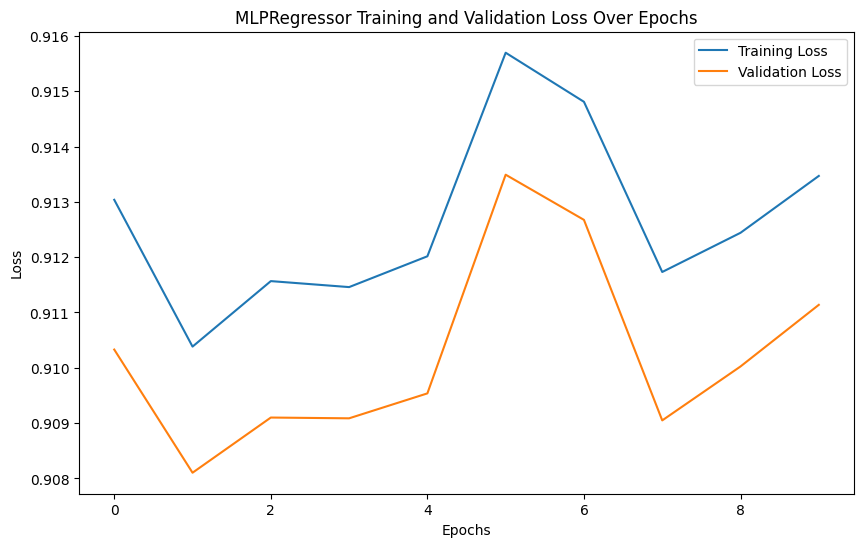

In [50]:
# Plot the cost function over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss_1, label='Training Loss')
plt.plot(range(epochs), valid_loss_1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLPRegressor Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [68]:
# Initialize the model
model1 = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', learning_rate_init=0.025, random_state=42)

In [72]:
epochs = 10
batch_size = 256
train_loss_1 = []
valid_loss_1 = []

for epoch in range(epochs):
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]
    
    for start in range(0, X_train.shape[0], batch_size):
        end = start + batch_size
        X_batch, y_batch = X_train[start:end], y_train[start:end]
        model1.partial_fit(X_batch, y_batch)

    y_train_pred = model1.predict(X_train)
    y_valid_pred = model1.predict(X_valid)
    train_loss_1.append(mean_squared_error(y_train, y_train_pred))
    valid_loss_1.append(mean_squared_error(y_valid, y_valid_pred))

    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss_1[-1]}, Validation Loss: {valid_loss_1[-1]}")

Epoch 1/10 - Training Loss: 0.9192982985152818, Validation Loss: 0.9166742591202951
Epoch 2/10 - Training Loss: 0.9161606869098122, Validation Loss: 0.9134969748152251
Epoch 3/10 - Training Loss: 0.9202253029513133, Validation Loss: 0.9180379248061438
Epoch 4/10 - Training Loss: 0.9189931544971791, Validation Loss: 0.9163295540072939
Epoch 5/10 - Training Loss: 0.919657166314637, Validation Loss: 0.9162866932621168
Epoch 6/10 - Training Loss: 0.9197601114278328, Validation Loss: 0.917120056789086
Epoch 7/10 - Training Loss: 0.925165382547052, Validation Loss: 0.9227175118601436
Epoch 8/10 - Training Loss: 0.9233734983283168, Validation Loss: 0.9202205842363492
Epoch 9/10 - Training Loss: 0.9238301290441268, Validation Loss: 0.9218590509650595
Epoch 10/10 - Training Loss: 0.9217553491103144, Validation Loss: 0.9192350748784173


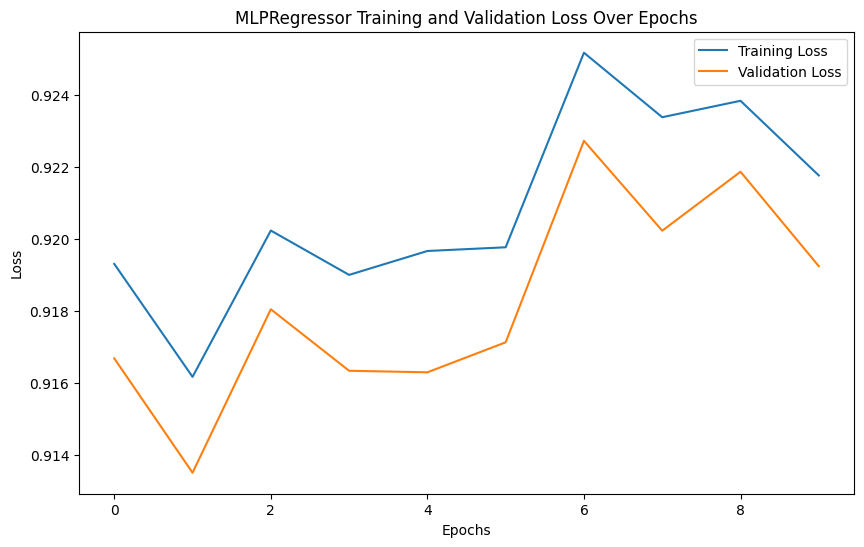

In [73]:
# Plot the cost function over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss_1, label='Training Loss')
plt.plot(range(epochs), valid_loss_1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLPRegressor Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [30]:
model = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', learning_rate_init=0.001, random_state=42)

In [32]:
# Track loss over epochs with mini-batches
epochs = 5  # Adjust number of epochs as needed
batch_size = 256  # Adjust batch size as needed
train_loss_2 = []
valid_loss_2 = []

for epoch in range(epochs):
    # Shuffle the training data
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Train in mini-batches
    for start in range(0, X_train.shape[0], batch_size):
        end = start + batch_size
        X_batch, y_batch = X_train[start:end], y_train[start:end]
        model.partial_fit(X_batch, y_batch)

    # Calculate training and validation loss
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    train_loss_2.append(mean_squared_error(y_train, y_train_pred))
    valid_loss_2.append(mean_squared_error(y_valid, y_valid_pred))

    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss_2[-1]}, Validation Loss: {valid_loss_2[-1]}")

Epoch 1/5 - Training Loss: 0.9108134682559722, Validation Loss: 0.9086847090271377
Epoch 2/5 - Training Loss: 0.9099916032175833, Validation Loss: 0.9074644796640702
Epoch 3/5 - Training Loss: 0.9099710952238902, Validation Loss: 0.9072758578380291
Epoch 4/5 - Training Loss: 0.9140618114213617, Validation Loss: 0.911193499896588
Epoch 5/5 - Training Loss: 0.9112965301103296, Validation Loss: 0.9088758192064414


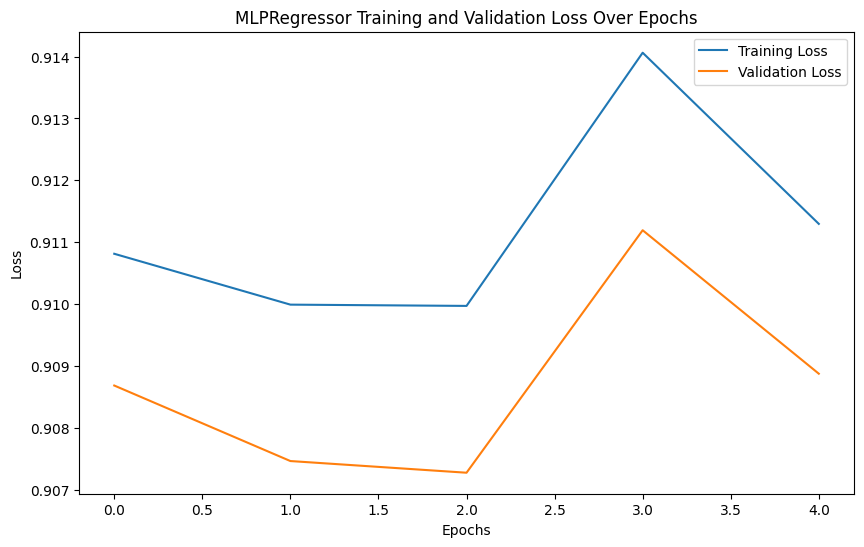

In [33]:
# Plot the cost function over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss_2, label='Training Loss')
plt.plot(range(epochs), valid_loss_2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLPRegressor Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [37]:
model3 = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', learning_rate_init=0.0001, random_state=42)

In [38]:
# Track loss over epochs with mini-batches
epochs = 5  # Adjust number of epochs as needed
batch_size = 256  # Adjust batch size as needed
train_loss_3 = []
valid_loss_3 = []

for epoch in range(epochs):
    # Shuffle the training data
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Train in mini-batches
    for start in range(0, X_train.shape[0], batch_size):
        end = start + batch_size
        X_batch, y_batch = X_train[start:end], y_train[start:end]
        model3.partial_fit(X_batch, y_batch)

    # Calculate training and validation loss
    y_train_pred = model3.predict(X_train)
    y_valid_pred = model3.predict(X_valid)
    train_loss_3.append(mean_squared_error(y_train, y_train_pred))
    valid_loss_3.append(mean_squared_error(y_valid, y_valid_pred))

    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss_3[-1]}, Validation Loss: {valid_loss_3[-1]}")

Epoch 1/5 - Training Loss: 0.9091867890265453, Validation Loss: 0.9065318540272349
Epoch 2/5 - Training Loss: 0.9094869170561547, Validation Loss: 0.9069005466856647
Epoch 3/5 - Training Loss: 0.9096484121860141, Validation Loss: 0.9074317813233546
Epoch 4/5 - Training Loss: 0.9091198042861908, Validation Loss: 0.9063670803651561
Epoch 5/5 - Training Loss: 0.9094203606966975, Validation Loss: 0.9070598485302933


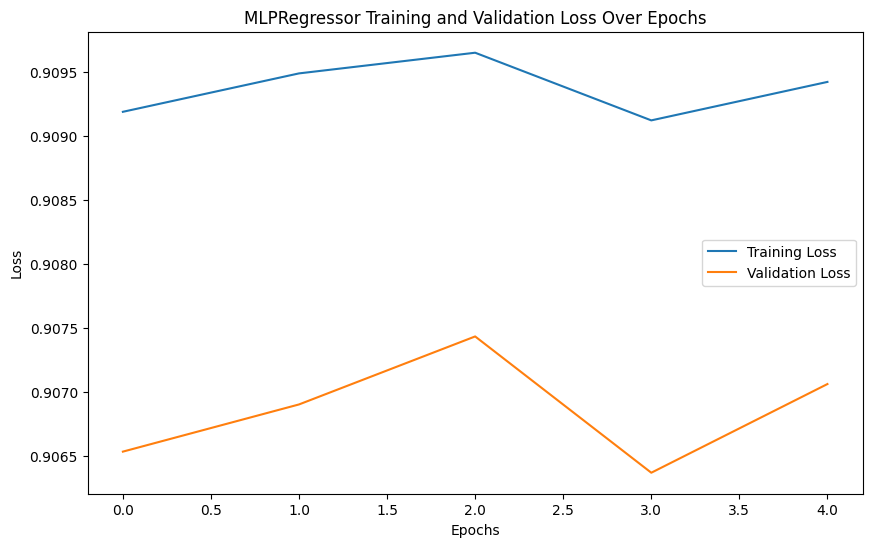

In [39]:
# Plot the cost function over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss_3, label='Training Loss')
plt.plot(range(epochs), valid_loss_3, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLPRegressor Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [42]:
model4 = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', learning_rate_init=0.05, random_state=42)

In [43]:
# Track loss over epochs with mini-batches
epochs = 5  # Adjust number of epochs as needed
batch_size = 256  # Adjust batch size as needed
train_loss_4 = []
valid_loss_4 = []

for epoch in range(epochs):
    # Shuffle the training data
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Train in mini-batches
    for start in range(0, X_train.shape[0], batch_size):
        end = start + batch_size
        X_batch, y_batch = X_train[start:end], y_train[start:end]
        model4.partial_fit(X_batch, y_batch)

    # Calculate training and validation loss
    y_train_pred = model4.predict(X_train)
    y_valid_pred = model4.predict(X_valid)
    train_loss_4.append(mean_squared_error(y_train, y_train_pred))
    valid_loss_4.append(mean_squared_error(y_valid, y_valid_pred))

    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss_4[-1]}, Validation Loss: {valid_loss_4[-1]}")

Epoch 1/5 - Training Loss: 0.9250775261686609, Validation Loss: 0.9230829570991954
Epoch 2/5 - Training Loss: 0.9357448504948229, Validation Loss: 0.9331359519128118
Epoch 3/5 - Training Loss: 0.9415784933273235, Validation Loss: 0.93849623190589
Epoch 4/5 - Training Loss: 0.9373291485095208, Validation Loss: 0.9346248076268527
Epoch 5/5 - Training Loss: 0.9600955964450191, Validation Loss: 0.9584017331539134


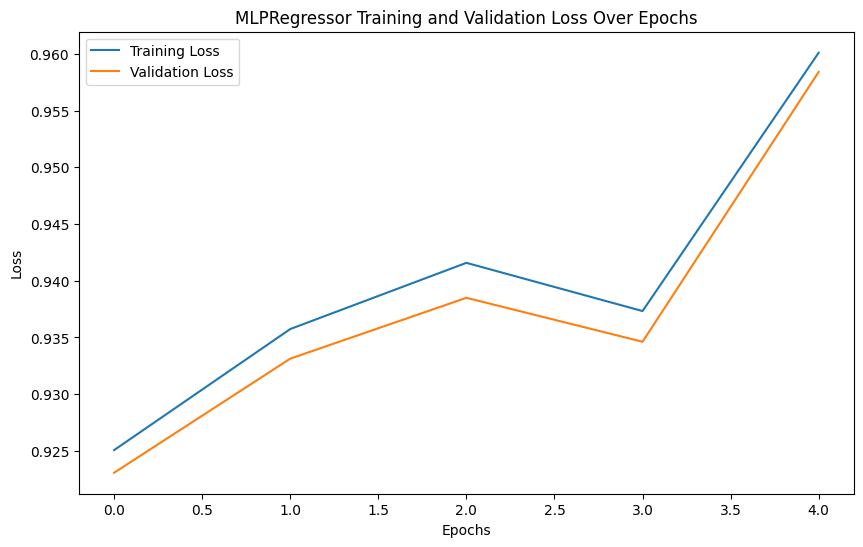

In [44]:
# Plot the cost function over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss_4, label='Training Loss')
plt.plot(range(epochs), valid_loss_4, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLPRegressor Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

Training with 10 neurons in the hidden layer


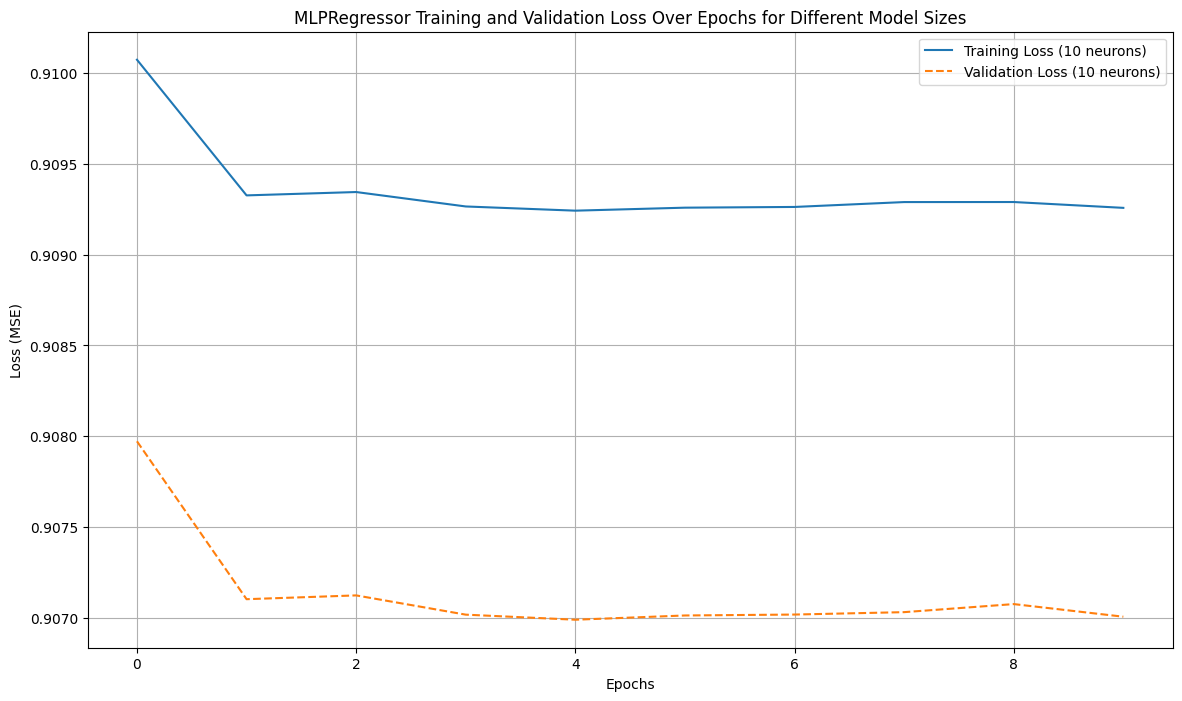

In [51]:
epochs = 10
learning_rate = 0.01
neurons = 10

print(f"Training with {neurons} neurons in the hidden layer")
model = MLPRegressor(hidden_layer_sizes=(neurons,), solver='sgd', alpha=0.0, 
                     learning_rate='constant', learning_rate_init=learning_rate, 
                     max_iter=200, warm_start=True, random_state=42)
train_loss_n1 = []
valid_loss_n1 = []
for epoch in range(epochs):
    model.fit(X_train, y_train)
    train_loss_n1.append(mean_squared_error(y_train, model.predict(X_train)))
    valid_loss_n1.append(mean_squared_error(y_valid, model.predict(X_valid)))
plt.figure(figsize=(14, 8))

plt.plot(range(epochs), train_loss_n1, label=f'Training Loss ({neurons} neurons)')
plt.plot(range(epochs), valid_loss_n1, linestyle='--', label=f'Validation Loss ({neurons} neurons)')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('MLPRegressor Training and Validation Loss Over Epochs for Different Model Sizes')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
train_loss_n1, valid_loss_n1

([0.9100724803131675,
  0.9093258197294851,
  0.9093442914270391,
  0.9092648664186742,
  0.909241744890216,
  0.9092582371586994,
  0.9092621902264552,
  0.9092890457082801,
  0.9092893304919687,
  0.9092571929809455],
 [0.9079724500576745,
  0.9071034497792836,
  0.9071243301805111,
  0.9070183614320104,
  0.9069904723109109,
  0.9070138516763389,
  0.9070189199574774,
  0.9070321634486549,
  0.9070764967714534,
  0.9070070628520291])

Training with 50 neurons in the hidden layer


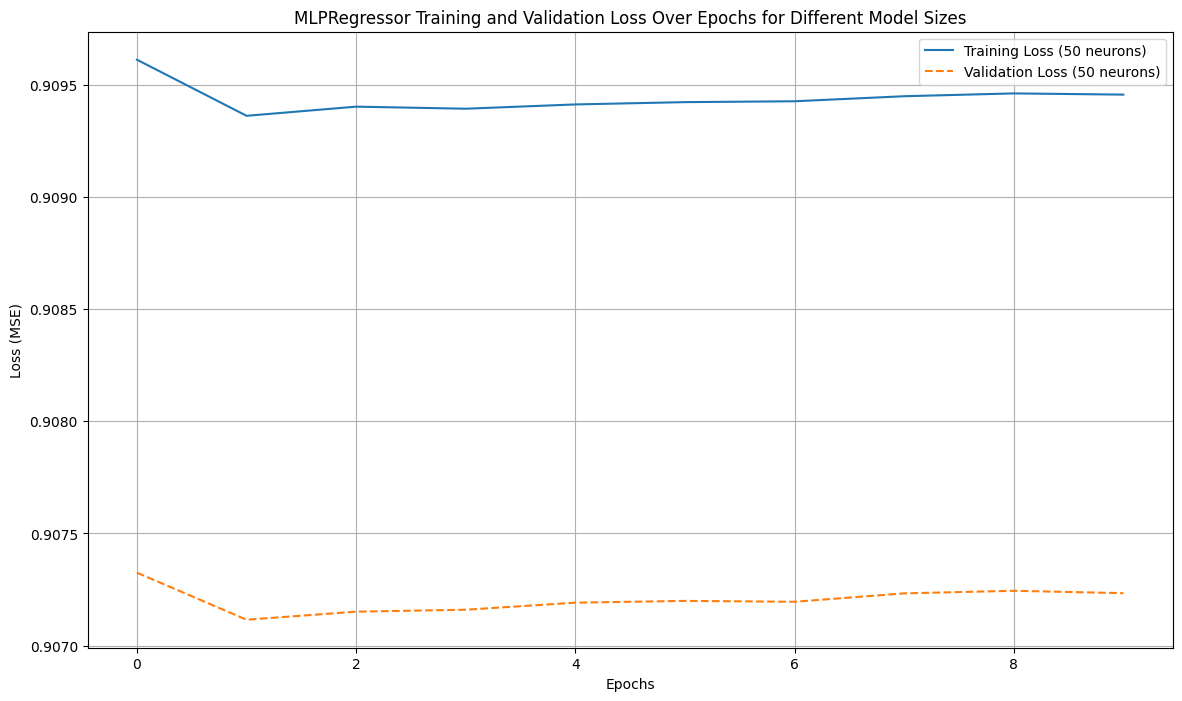

In [54]:
neurons = 50

print(f"Training with {neurons} neurons in the hidden layer")

model = MLPRegressor(hidden_layer_sizes=(neurons,), solver='sgd', alpha=0.0, 
                     learning_rate='constant', learning_rate_init=learning_rate, 
                     max_iter=200, warm_start=True, random_state=42)

train_loss_n2 = []
valid_loss_n2 = []
for epoch in range(epochs):
    model.fit(X_train, y_train)
    train_loss_n2.append(mean_squared_error(y_train, model.predict(X_train)))
    valid_loss_n2.append(mean_squared_error(y_valid, model.predict(X_valid)))

plt.figure(figsize=(14, 8))

plt.plot(range(epochs), train_loss_n2, label=f'Training Loss ({neurons} neurons)')
plt.plot(range(epochs), valid_loss_n2, linestyle='--', label=f'Validation Loss ({neurons} neurons)')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('MLPRegressor Training and Validation Loss Over Epochs for Different Model Sizes')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
train_loss_n2, valid_loss_n2

([0.9096123095148251,
  0.9093622405338097,
  0.9094030563208881,
  0.9093938442088082,
  0.9094129188463336,
  0.909423192945346,
  0.9094270866706526,
  0.9094495085238882,
  0.9094621116953089,
  0.9094567090994234],
 [0.9073249685602388,
  0.9071153266482069,
  0.9071512525776181,
  0.9071598541477054,
  0.9071913409453335,
  0.9071992786729922,
  0.9071953467890738,
  0.9072328001113094,
  0.9072443717135039,
  0.9072337556396848])

Training with 100 neurons in the hidden layer


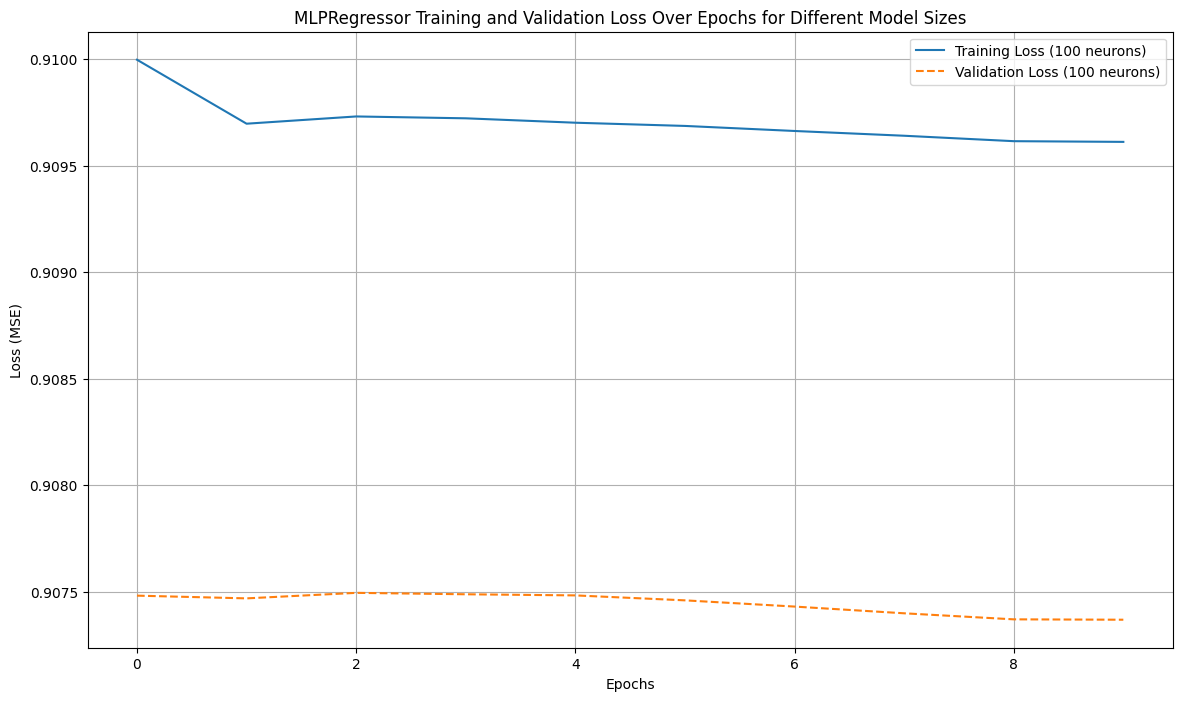

In [57]:
neurons = 100

print(f"Training with {neurons} neurons in the hidden layer")

model = MLPRegressor(hidden_layer_sizes= (neurons, ), solver='sgd', alpha=0.0, 
                     learning_rate='constant', learning_rate_init=learning_rate, 
                     max_iter=200, warm_start=True, random_state=42)

train_loss_n3 = []
valid_loss_n3 = []
for epoch in range(epochs):
    model.fit(X_train, y_train)
    train_loss_n3.append(mean_squared_error(y_train, model.predict(X_train)))
    valid_loss_n3.append(mean_squared_error(y_valid, model.predict(X_valid)))

plt.figure(figsize=(14, 8))

plt.plot(range(epochs), train_loss_n3, label=f'Training Loss ({neurons} neurons)')
plt.plot(range(epochs), valid_loss_n3, linestyle='--', label=f'Validation Loss ({neurons} neurons)')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('MLPRegressor Training and Validation Loss Over Epochs for Different Model Sizes')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
train_loss_n3, valid_loss_n3

([0.9099976958731515,
  0.9096972219291874,
  0.9097312596980985,
  0.9097225298495941,
  0.9097018630626499,
  0.9096867554524721,
  0.90966302755182,
  0.9096406495690335,
  0.9096151392065379,
  0.9096118463018339],
 [0.9074806909215696,
  0.907467873734319,
  0.9074937931544196,
  0.9074871379182624,
  0.9074818213084871,
  0.9074585930032997,
  0.9074293486354973,
  0.9073977922030407,
  0.907369386682408,
  0.9073676134820157])

In [76]:
scaler = StandardScaler()
joke_text = ["What did the pirate say when he turned 80? Aye matey."]
model_transformer = SentenceTransformer(model_name)

In [77]:
joke_embeddings = model_transformer.encode(joke_text)
joke_embeddings = scaler.fit_transform(joke_embeddings)

In [ ]:
best_model = MLPRegressor(hidden_layer_sizes=(10,), solver='sgd', alpha=0.0, learning_rate='constant', learning_rate_init=0.01, random_state=42)
best_model.fit(X_train, y_train)

In [ ]:
predicted_humor_scores = best_model.predict(joke_embeddings)

print(f"Predicted Humor Scores: {predicted_humor_scores}")